In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
df = pd.read_csv('../ranking/custom_rounded_score.csv')

In [7]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [13]:
train_features = train_df.copy()[['eleve','classe','min','max','score']]
test_features = test_df.copy()[['eleve','classe','min','max','score']]

train_labels = train_features.pop('score')
test_labels = test_features.pop('score')

In [17]:
train_df.describe().transpose()[['mean', 'std']]

,mean,std
eleve,12.518844,3.441550
classe,12.092705,2.012112
min,5.402816,3.442016
max,17.819241,1.687189
label,3.595584,1.000166
accuracy,0.565784,0.102314
skew,0.240838,0.584088
delta,0.262129,0.795336
scale,2.774214,0.411905
location,11.424501,2.298904


## Normalization

In [18]:
normalizer = preprocessing.Normalization(axis=-1)

In [19]:
normalizer.adapt(np.array(train_features))

In [22]:
normalizer.mean.numpy()

array([12.519, 12.093,  5.403, 17.819], dtype=float32)

In [26]:
# Example
first = np.array(train_features[:1])
first, normalizer(first).numpy()

(array([[14.2 , 11.62,  2.9 , 19.8 ]]),
 array([[ 0.489, -0.235, -0.727,  1.174]], dtype=float32))

## Linear regression

In [27]:
# Create Normalization layer
eleve = np.array(train_features['eleve'])
elever_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
elever_normalizer.adapt(eleve)

In [28]:
# Build sequential model
eleve_model = tf.keras.Sequential([
  elever_normalizer,
  layers.Dense(units=1)
])

eleve_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [32]:
eleve_model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  loss="mean_absolute_error"
)

In [34]:
history = eleve_model.fit(
  train_features['eleve'], train_labels,
  epochs=100,
  verbose=0,
  validation_split=0.2
)

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,0.481740,0.475967,0
1,0.476470,0.475775,1
2,0.477847,0.488704,2
3,0.479338,0.479284,3
4,0.477584,0.491234,4
...,...,...,...
95,0.477125,0.480600,95
96,0.478170,0.479135,96
97,0.477161,0.489539,97
98,0.477344,0.484866,98


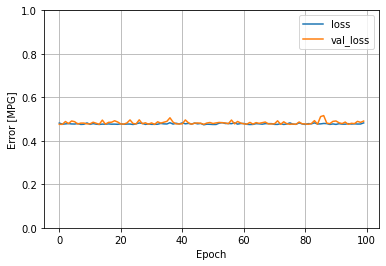

In [40]:
def plot_loss(history):
  plt.plot(history.history['loss'], label="loss")
  plt.plot(history.history['val_loss'], label="val_loss")
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [41]:
test_results = {}
test_results['eleve_model'] = eleve_model.evaluate(
  test_features['eleve'],
  test_labels,
  verbose=0
)

In [47]:
x = tf.linspace(0,20,21)
y = eleve_model.predict(x)

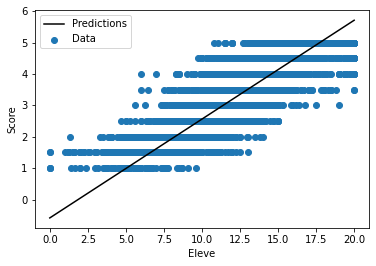

In [48]:
def plot_eleve(x, y):
  plt.scatter(train_features['eleve'], train_labels, label="Data")
  plt.plot(x, y, color='k', label="Predictions")
  plt.xlabel('Eleve')
  plt.ylabel('Score')
  plt.legend()

plot_eleve(x, y)

## Multiple inputs

In [49]:
linear_model = tf.keras.Sequential([
  normalizer,
  layers.Dense(units=1)
])

In [53]:
linear_model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  loss="mean_absolute_error"
)

In [55]:
history = linear_model.fit(
  train_features,
  train_labels,
  epochs=100,
  verbose=0,
  validation_split=0.2
)

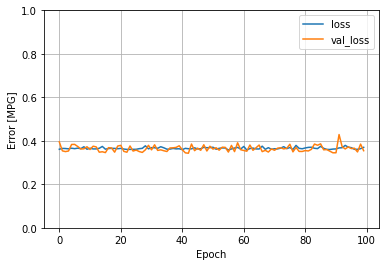

In [56]:
plot_loss(history)

In [57]:
test_results['linear_model'] = linear_model.evaluate(
  test_features, test_labels, verbose=0
)


## DNN

In [183]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1),
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

### One variable

In [67]:
dnn_eleve_model = build_and_compile_model(elever_normalizer)
dnn_eleve_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [68]:
history = dnn_eleve_model.fit(
  train_features['eleve'],
  train_labels,
  verbose=0,
  validation_split=0.2,
  epochs=100
)

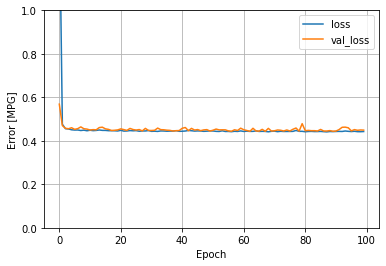

In [69]:
plot_loss(history)

In [70]:
x = tf.linspace(0,20,21)
y = dnn_eleve_model.predict(x)

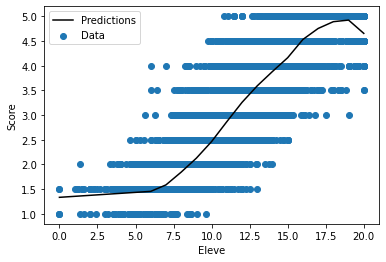

In [71]:
plot_eleve(x,y)

In [72]:
test_results['dnn_eleve_model'] = dnn_eleve_model.evaluate(
  test_features['eleve'],
  test_labels,
  verbose=0
)

### Full model

In [173]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_27 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 4,698
Trainable params: 4,689
Non-trainable params: 9
_________________________________________________________________


In [174]:
history = dnn_model.fit(
  train_features,
  train_labels,
  validation_split=0.2,
  epochs=100,
  verbose=0,
)

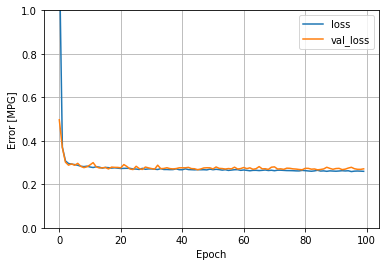

In [175]:
plot_loss(history)

In [176]:
history.history['loss'][-1]

0.2597724199295044

In [177]:
test_results['dnn_model'] = dnn_model.evaluate(
  test_features,
  test_labels,
  verbose=0
)

## Performance

In [178]:
pd.DataFrame(test_results, index=["Mean absolute error"]).T

,Mean absolute error
eleve_model,0.497202
linear_model,0.365962
dnn_eleve_model,0.451297
dnn_model,0.268203


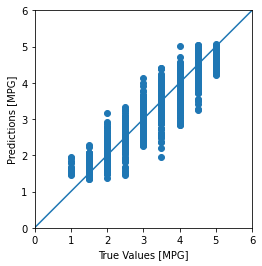

In [179]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


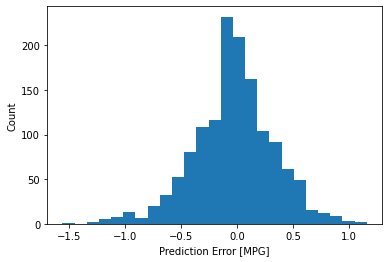

In [180]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


## Test against rounded values

In [181]:
df_expanded = train_df.loc[train_features.index]
df_expanded['prediction'] = pd.DataFrame(dnn_model.predict(train_features))
df_expanded.dropna(inplace=True)
df_expanded['prediction_semi'] = df_expanded['prediction'].apply(lambda x: round(x * 2) / 2)
df_expanded['prediction_rounded'] = df_expanded['prediction'].apply(lambda x: round(x))
df_expanded.head(2)

,eleve,classe,min,max,commentaire,label,accuracy,skew,delta,scale,location,shape,stars,score,rounded_score,prediction,prediction_semi,prediction_rounded
5396,14.20,11.62,2.90,19.8,Après un démarrage difficile tant du point de ...,3,0.457616,0.1350,0.704804,2.418679,10.259850,0.993519,5,4.0,4,4.810272,5.0,5
1270,11.83,13.76,10.37,17.3,"Après un début de trimestre difficile, les rés...",4,0.495505,-0.0375,-0.508339,2.188058,14.647468,-0.590298,2,3.0,3,1.550767,1.5,2


In [182]:
# The performance against the score / label is not great
abs(df_expanded['label'] - df_expanded['prediction_rounded']).describe()

count    4456.000000
mean        1.146768
std         0.922838
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         4.000000
dtype: float64

In [95]:
# Save
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
# Load
reloaded = tf.keras.models.load_model('dnn_model')
